In [3]:
%pylab notebook --no-import-all
%matplotlib notebook

from scipy import stats

from astropy import units as u
from astropy import constants as const

Populating the interactive namespace from numpy and matplotlib


In [4]:
PI     = np.pi
TWO_PI = 2*PI
h      = const.h

In [280]:
# determining the error of the angle
# measured angle sweep was 60 degrees

sixty_nums = np.array([3568, 3537, 3570])

def rot_ratio(arr, angle, d_angle=1):
    x   = np.mean(arr)
    sx  = np.std(arr)
    
    q   = angle / np.mean(arr)
    sq2 = (d_angle / x)**2 + ((angle / (x**2))*sx)**2
    
    return [q, sq2**(1/2)]

ratio   = rot_ratio(sixty_nums, 60)

# using a known wavelength to calibrate and determine d
sodium_lam = [589.0 * u.nm, 589.6 * u.nm]

In [317]:
#### HELPER FUNCTIONS

def true_angle(measured, r=ratio, ref_arr=sixty_nums):
    q   = measured * r[0]
    sq2 = ((measured.unit) * r[0] * np.std(ref_arr))**2 + (measured * r[1])**2
    
    return [q, sq2**(1/2)]

# angle is an array [[q1, dq1], [q2, dq2], ...]
def calibrate(angle, lam_set=sodium_lam, m_test=1):
    arr = np.zeros(len(angle) * len(lam_set))
    k   = 0
    
    for i in range(len(angle)):
        a  = [np.abs(angle[i][0].value) * angle[i][0].unit, np.abs(angle[i][1].value) * angle[i][1].unit]
        
        for j in range(len(lam_set)):
            arr[k] = (m_test * lam_set[j].to(u.m).value) / np.sin(a[0].to(u.rad).value)
            k += 1
    
    d  = np.mean(arr) * u.m
    sd = np.std(arr) * u.m
    
    return [d, sd]

def wavelength(angle, d, m_test=1):
    l   = (d[0] / m_test) * np.sin(angle[0].to(u.rad))
    dl2 = ((d[1] / m_test) * np.sin(angle[0].to(u.rad)))**2 + ((d[0] / m_test) * np.cos(angle[0].to(u.rad)) * d[1].value)**2
    
    return [l, dl2**(1/2)]

class WavelengthTester(object):
    
    # The wavelengths MUST be in order of shortest to longest
    def __init__(self, wavelengths):
        self.lams = wavelengths
    
    def test(self, data):
        p = 1
        
        for i in range(len(data)):
            assert type(data[i]) == float, 'Type of test data is not float[]'
            p *= self._region_test(data[i], mu=1e9*self.lams[i][0].value, std=1e9*self.lams[i][1].value)
        
        return p
    
    def test_all(self, *data):
        for i in range(len(data)):
            print('[%d]: %f' % (i+1, self.test(data[i])))
            
    # standard 2-sided z-test; scipy's function is a little func-y
    def _region_test(self, val, mu=1, std=1):
        z  = np.abs(val - mu) / std
        return 2*stats.norm.cdf(mu - z*std, loc=mu, scale=std)

<IPython.core.display.Javascript object>


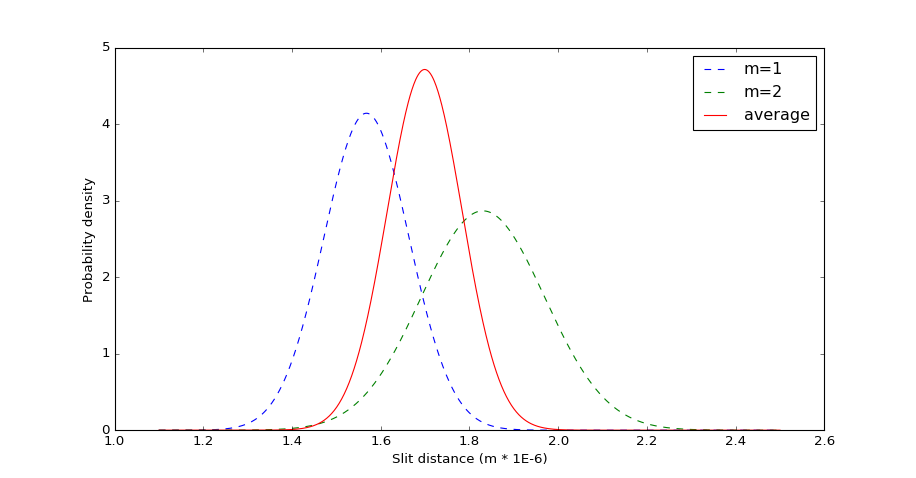

In [291]:
d1   = calibrate([true_angle((4050 - 2820) * u.degree), true_angle((1420 - 2820) * u.degree)])
d2   = calibrate([true_angle((5000 - 2820) * u.degree), true_angle((200 - 2820) * u.degree)], m_test=2)

dbar = [(d1[0] + d2[0]) / 2., (1/2.)*(d1[1]**2 + d2[1]**2)**(1/2)]

x  = np.linspace(1.1, 2.5, 1000)

plt.plot(x, mlab.normpdf(x, 1e6*d1[0].value, 1e6*d1[1].value), ls='--', label='m=1')
plt.plot(x, mlab.normpdf(x, 1e6*d2[0].value, 1e6*d2[1].value), ls='--', label='m=2')
plt.plot(x, mlab.normpdf(x, 1e6*dbar[0].value, 1e6*dbar[1].value), label='average')

plt.xlabel('Slit distance (m * 1E-6)')
plt.ylabel('Probability density')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


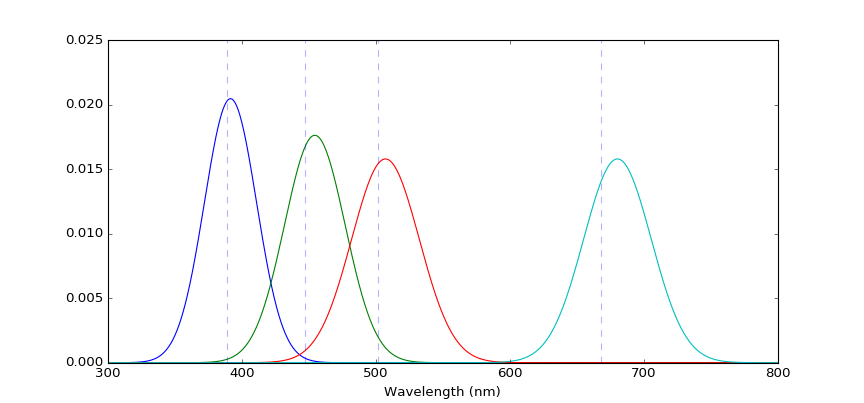

In [325]:
# line spectrum of He

l1_he = wavelength(true_angle(np.abs(3610 - 2820) * u.degree), d=dbar)
l2_he = wavelength(true_angle(np.abs(3740 - 2820) * u.degree), d=dbar)
l3_he = wavelength(true_angle(np.abs(3850 - 2820) * u.degree), d=dbar)
l4_he = wavelength(true_angle(np.abs(4220 - 2820) * u.degree), d=dbar)

lams  = np.linspace(300, 800, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_he[0].value, 1e9*l1_he[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_he[0].value, 1e9*l2_he[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l3_he[0].value, 1e9*l3_he[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l4_he[0].value, 1e9*l3_he[1].value))

plt.axvline(388.86, alpha=0.3, ls='--')
plt.axvline(447.14, alpha=0.3, ls='--')
plt.axvline(501.56, alpha=0.3, ls='--')
plt.axvline(667.81, alpha=0.3, ls='--')

plt.xlabel('Wavelength (nm)')

In [327]:
helium_tester = WavelengthTester([l1_he, l2_he, l3_he, l4_he])
HELIUM_TEST_1 = [388.86, 447.14, 501.56, 667.81]
HELIUM_TEST_2 = [388.86, 468.57, 501.56, 667.81]

helium_tester.test_all(HELIUM_TEST_1, HELIUM_TEST_2)

[1]: 0.390499
[2]: 0.277907


<IPython.core.display.Javascript object>


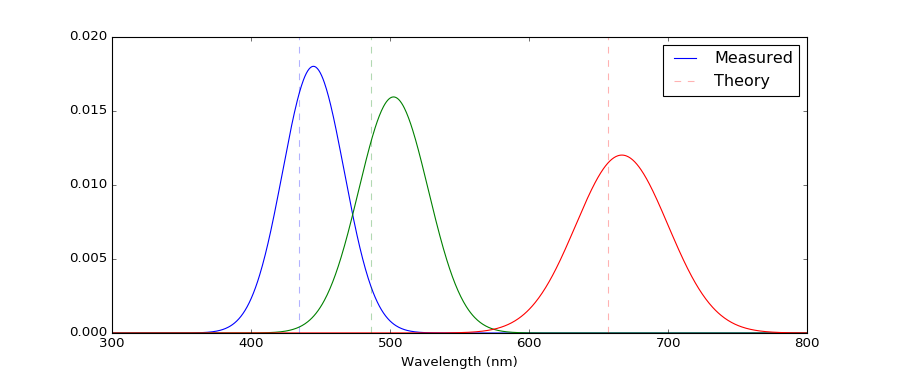

In [330]:
# line spectrum of H2

def balmer_hyd(n2):
    # l^-1 = R(n1^-2 - n2^-2)
    _R = 1.097e7 * (1 / u.m)
    n1 = 2
    
    if n2=='inf':
        return (_R * (n1**(-2)))**(-1)
    else:
        return (_R * (n1**(-2) - n2**(-2)))**(-1)

l1_h = wavelength(true_angle(np.abs(600 - 1500) * u.degree), d=dbar)
l2_h = wavelength(true_angle(np.abs(480 - 1500) * u.degree), d=dbar)
l3_h = wavelength(true_angle(np.abs(130 - 1500) * u.degree), d=dbar)

lams  = np.linspace(300, 800, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_h[0].value, 1e9*l1_h[1].value), label='Measured')
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_h[0].value, 1e9*l2_h[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l3_h[0].value, 1e9*l3_h[1].value))

plt.axvline(1e9 * balmer_hyd(3).value, alpha=0.3, color='r', ls='--', label='Theory')
plt.axvline(1e9 * balmer_hyd(4).value, alpha=0.3, color='g', ls='--')
plt.axvline(1e9 * balmer_hyd(5).value, alpha=0.3, color='b', ls='--')

plt.xlabel('Wavelength (nm)')
plt.legend(loc='upper right')

In [324]:
hydrogen_tester = WavelengthTester([l1_h, l2_h, l3_h])
HYDROGEN_TEST_1 = [1e9 * balmer_hyd(5).value, 1e9 * balmer_hyd(4).value, 1e9 * balmer_hyd(3).value]
HYDROGEN_TEST_2 = [434.04, 486.13, 656.28]

hydrogen_tester.test_all(HYDROGEN_TEST_1, HYDROGEN_TEST_2)

[1]: 0.245624
[2]: 0.244114


<IPython.core.display.Javascript object>


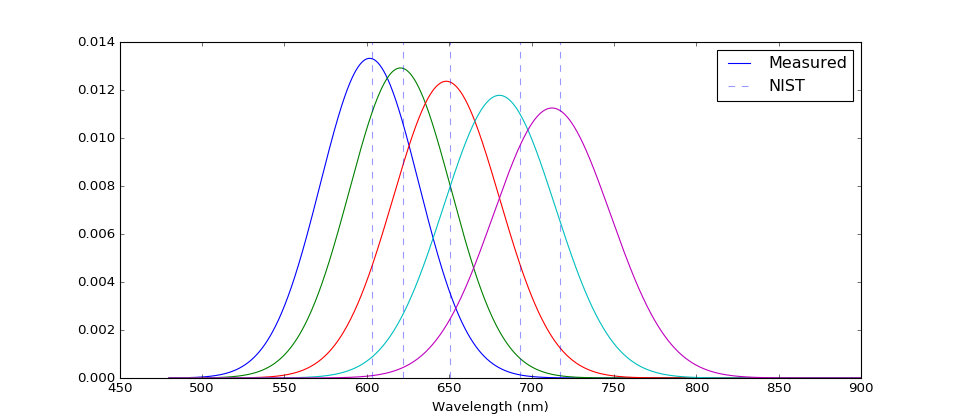

In [320]:
# line spectrum of Ne

l1_ne = wavelength(true_angle(np.abs(2610 - 1380) * u.degree), d=dbar)
l2_ne = wavelength(true_angle(np.abs(2650 - 1380) * u.degree), d=dbar)
l3_ne = wavelength(true_angle(np.abs(2710 - 1380) * u.degree), d=dbar)
l4_ne = wavelength(true_angle(np.abs(2780 - 1380) * u.degree), d=dbar)
l5_ne = wavelength(true_angle(np.abs(2850 - 1380) * u.degree), d=dbar)

lams  = np.linspace(480, 900, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_ne[0].value, 1e9*l1_ne[1].value), label='Measured')
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_ne[0].value, 1e9*l2_ne[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l3_ne[0].value, 1e9*l3_ne[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l4_ne[0].value, 1e9*l4_ne[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l5_ne[0].value, 1e9*l5_ne[1].value))

# Data from NIST
# http://physics.nist.gov/PhysRefData/Handbook/Tables/neontable3.htm#7173.9381
# http://nist.gov/data/PDFfiles/jpcrd690.pdf
plt.axvline(602.99969, alpha=0.4, ls='--', label='NIST')
plt.axvline(621.72812, alpha=0.4, ls='--')
plt.axvline(650.65281, alpha=0.4, ls='--')
plt.axvline(692.94673, alpha=0.4, ls='--')
plt.axvline(717.39381, alpha=0.4, ls='--')

plt.xlabel('Wavelength (nm)')
plt.legend(loc='upper right')

In [318]:
neon_tester = WavelengthTester([l1_ne, l2_ne, l3_ne, l4_ne, l5_ne])

NEON_TEST_1 = [602.99, 621.72, 650.65, 692.94, 717.39]
NEON_TEST_2 = [607.43, 616.35, 640.22, 692.94, 717.39]
NEON_TEST_3 = [607.43, 616.35, 650.65, 692.94, 717.39]
NEON_TEST_4 = [602.99, 616.35, 650.65, 692.94, 717.39]
NEON_TEST_5 = [602.99, 621.72, 650.65, 659.89, 717.39]

neon_tester.test_all(NEON_TEST_1, NEON_TEST_2, NEON_TEST_3, NEON_TEST_4, NEON_TEST_5)

[1]: 0.551632
[2]: 0.386046
[3]: 0.450431
[4]: 0.512759
[5]: 0.422474


<IPython.core.display.Javascript object>


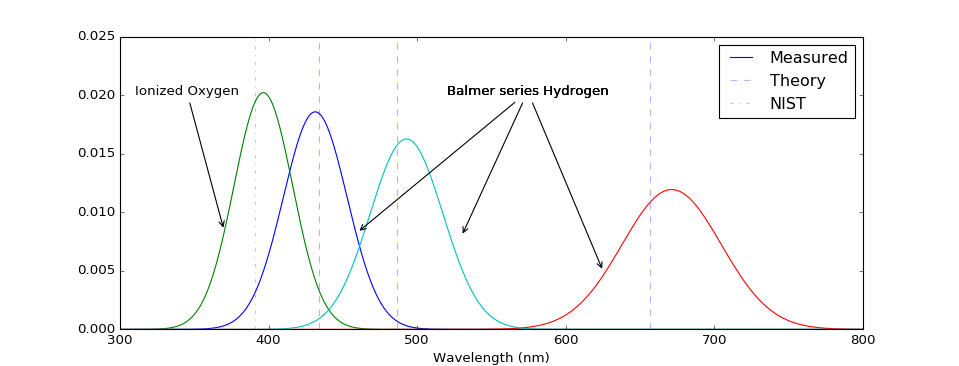

In [300]:
## line spectrum of H2O

l1_h2o = wavelength(true_angle(np.abs(4170 - 2360) * u.degree), d=dbar, m_test=2)
l2_h2o = wavelength(true_angle(np.abs(4010 - 2360) * u.degree), d=dbar, m_test=2)
l3_h2o = wavelength(true_angle(np.abs(3740 - 2360) * u.degree), d=dbar)
l4_h2o = wavelength(true_angle(np.abs(3360 - 2360) * u.degree), d=dbar)

lams  = np.linspace(300, 800, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_h2o[0].value, 1e9*l1_h2o[1].value), label='Measured')
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_h2o[0].value, 1e9*l2_h2o[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l3_h2o[0].value, 1e9*l3_h2o[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l4_h2o[0].value, 1e9*l4_h2o[1].value))

plt.axvline(1e9 * balmer_hyd(3).value, alpha=0.3, color='b', ls='--', label='Theory')
plt.axvline(1e9 * balmer_hyd(4).value, alpha=0.3, color='b', ls='--')
plt.axvline(1e9 * balmer_hyd(5).value, alpha=0.3, color='b', ls='--')
plt.axvline(391.19, alpha=0.3, ls='-.', color='g', label='NIST')

plt.axes().annotate('Balmer series Hydrogen', 
                    xy=(460, 0.0083), xycoords='data', 
                    xytext=(520, 0.02), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.axes().annotate('Balmer series Hydrogen', 
                    xy=(530, 0.008), xycoords='data', 
                    xytext=(520, 0.02), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.axes().annotate('Balmer series Hydrogen', 
                    xy=(625, 0.005), xycoords='data', 
                    xytext=(520, 0.02), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.axes().annotate('Ionized Oxygen', 
                    xy=(370, 0.0085), xycoords='data', 
                    xytext=(310, 0.020), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.xlabel('Wavelength (nm)')
plt.legend(loc='upper right')

In [329]:
water_tester = WavelengthTester([l2_h2o, l1_h2o, l4_h2o, l3_h2o])
WATER_TEST_1 = [391.19, 1e9 * balmer_hyd(5).value, 1e9 * balmer_hyd(4).value, 1e9 * balmer_hyd(3).value]
WATER_TEST_2 = [391.19, 434.04, 486.13, 656.28]

water_tester.test_all(WATER_TEST_1, WATER_TEST_2)

[1]: 0.366002
[2]: 0.365347


<IPython.core.display.Javascript object>


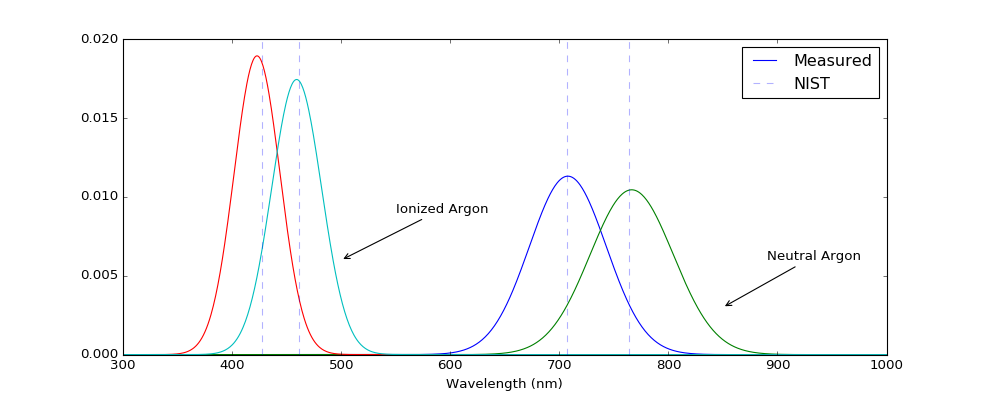

In [302]:
## line spectrum of Ar

l1_ar = wavelength(true_angle(np.abs(2970 - 1510) * u.degree), d=dbar)
l2_ar = wavelength(true_angle(np.abs(3100 - 1510) * u.degree), d=dbar)
# l3_ar = wavelength(true_angle(np.abs(3220 - 1510) * u.degree), d=dbar)
l4_ar = wavelength(true_angle(np.abs(3280 - 1510) * u.degree), d=dbar, m_test=2)
l5_ar = wavelength(true_angle(np.abs(3450 - 1510) * u.degree), d=dbar, m_test=2)

lams  = np.linspace(300, 1000, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_ar[0].value, 1e9*l1_ar[1].value), label='Measured')
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_ar[0].value, 1e9*l2_ar[1].value))
# plt.plot(lams, mlab.normpdf(lams, 1e9*l3_ar[0].value, 1e9*l3_ar[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l4_ar[0].value, 1e9*l4_ar[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l5_ar[0].value, 1e9*l5_ar[1].value))

plt.axvline(427.75, alpha=0.3, ls='--', label='NIST')
plt.axvline(460.96, alpha=0.3, ls='--')
plt.axvline(706.72, alpha=0.3, ls='--')
plt.axvline(763.51, alpha=0.3, ls='--')

plt.axes().annotate('Ionized Argon', 
                    xy=(500, 0.006), xycoords='data', 
                    xytext=(550, 0.009), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.axes().annotate('Neutral Argon', 
                    xy=(850, 0.003), xycoords='data', 
                    xytext=(890, 0.006), textcoords='data',
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle='arc3'))

plt.xlabel('Wavelength (nm)')
plt.legend(loc='upper right')

In [321]:
argon_tester  = WavelengthTester([l4_ar, l5_ar, l1_ar, l2_ar])
ARGON_TEST_1  = [427.75, 460.96, 706.72, 763.51]
ARGON_TEST_2  = [427.75, 476.48, 696.54, 763.51]

argon_tester.test_all(ARGON_TEST_1, ARGON_TEST_2)

[1]: 0.698391
[2]: 0.256435


<IPython.core.display.Javascript object>


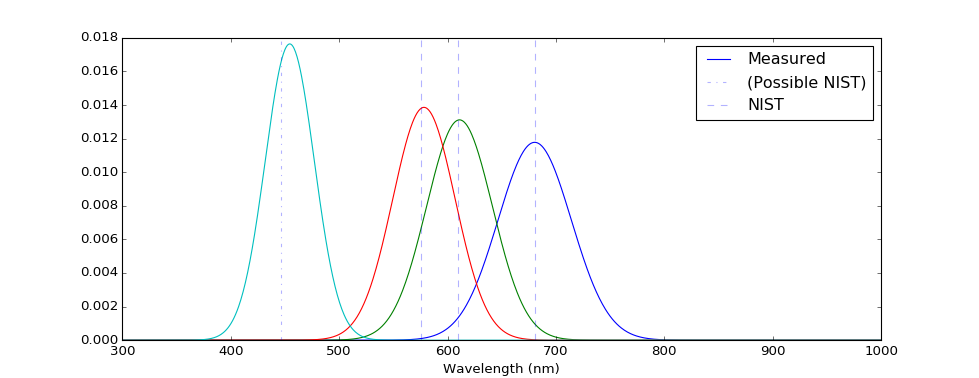

In [304]:
## line spectrum of mystery box

l1_mys = wavelength(true_angle(np.abs(280 - 1680) * u.degree), d=dbar)
l2_mys = wavelength(true_angle(np.abs(430 - 1680) * u.degree), d=dbar)
l3_mys = wavelength(true_angle(np.abs(500 - 1680) * u.degree), d=dbar)
l4_mys = wavelength(true_angle(np.abs(760 - 1680) * u.degree), d=dbar)

lams  = np.linspace(300, 1000, 1000)

plt.plot(lams, mlab.normpdf(lams, 1e9*l1_mys[0].value, 1e9*l1_mys[1].value), label='Measured')
plt.plot(lams, mlab.normpdf(lams, 1e9*l2_mys[0].value, 1e9*l2_mys[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l3_mys[0].value, 1e9*l3_mys[1].value))
plt.plot(lams, mlab.normpdf(lams, 1e9*l4_mys[0].value, 1e9*l4_mys[1].value))

plt.axvline(446.22, alpha=0.3, ls='-.', label='(Possible NIST)')
plt.axvline(575.10, alpha=0.3, ls='--', label='NIST')
plt.axvline(609.76, alpha=0.3, ls='--')
plt.axvline(680.57, alpha=0.3, ls='--')

plt.xlabel('Wavelength (nm)')
plt.legend(loc='upper right')

# DETERMINATION: IONIZED XENON

In [307]:
mys_test     = WavelengthTester([l4_mys, l3_mys, l2_mys, l1_mys])
XENON_GUESS  = [446.22, 575.10, 609.76, 680.57]
OXYGEN_GUESS = [397.32, 464.91, 615.81, 777.19]
HG_GUESS     = [435.83, 546.07, 614.94, 794.45]

mys_test.test(XENON_GUESS) * 100, mys_test.test(OXYGEN_GUESS) * 100, mys_test.test(HG_GUESS) * 100

(62.996498838837958, 3.5660926971025011e-07, 0.0073884907580339006)